In [1]:
from UNet import *
import numpy as np
import matplotlib.pyplot as plt
import deepdish as dd

### load data

In [2]:
raw_image = dd.io.load('sample_origonal_images.h5')
vector_field = dd.io.load('vector_fields.h5')

In [3]:
raw_image[0].shape[0]

840

In [4]:
n_imgs = len(raw_image)
n_input_channel = 1
n_vf_channel = 4
size = raw_image[0].shape[0]
raw_image = raw_image.reshape(n_imgs, n_input_channel, size, size)

### downsample both input images and vector fields

In [5]:
factor = 9

In [6]:
down_inputs = raw_image[:,:, ::factor,::factor] / factor

In [7]:
down_vf = vector_field[:, :, ::factor, ::factor] / factor

In [8]:
down_inputs.shape

(105, 1, 94, 94)

In [9]:
down_vf.shape

(105, 4, 94, 94)

### zero padding in order to get tensor consistency

In [10]:
down_inputs_pad = np.zeros((n_imgs, n_input_channel, 96, 96))
down_vf_pad = np.zeros((n_imgs, n_vf_channel, 96, 96))

In [11]:
down_inputs_pad[:,:,:94, :94] = down_inputs
down_vf_pad[:,:,:94, :94] = down_vf

In [12]:
down_inputs_pad.shape

(105, 1, 96, 96)

In [13]:
down_vf_pad.shape

(105, 4, 96, 96)

### downsampling dataset visualization

In [14]:
size = down_inputs.shape[-1]

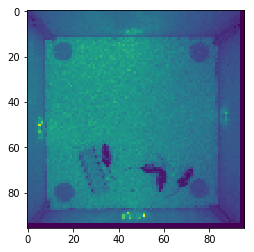

In [15]:
plt.imshow(down_inputs_pad[0].reshape(96, 96))
plt.show()

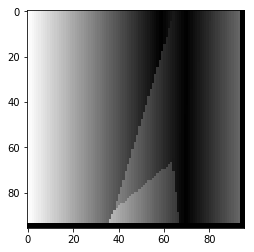

In [16]:
plt.imshow(np.abs(down_vf_pad[0,0]), cmap='gray')
plt.show()

### set hyperparameters

In [17]:
batch_size = 5
img_size = down_inputs.shape[-1]
lr = .0002
epoch = 10

### transform to torch tensor

In [18]:
tensor_x = torch.stack([torch.Tensor(i) for i in down_inputs_pad])
tensor_y = torch.stack([torch.Tensor(i) for i in down_vf_pad])

### create dataset

In [19]:
my_dataset = data.TensorDataset(tensor_x, tensor_y)

In [20]:
my_dataset.target_tensor.shape

torch.Size([105, 4, 96, 96])

In [21]:
my_dataset.data_tensor.shape

torch.Size([105, 1, 96, 96])

### input pipeline

In [22]:
img_batch = data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

### initiate U-Net model generator

In [23]:
generator = UnetGenerator(1, 4, 64) # using CPU
#generator = nn.DataParallel(UnetGenerator(1, 4, 64)).cuda() # using GPU


------Initiating U-Net------



### set loss function and optimizer

In [24]:
recon_loss_func = nn.MSELoss()
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

### training the model

In [25]:
for i in range(epoch):
    for k, (img, vec_field) in enumerate(img_batch):
        gen_optimizer.zero_grad()
        x = Variable(img)#.cuda(0)
        y_ = Variable(vec_field)#.cuda(0)
        y = generator.forward(x)
        loss = recon_loss_func(y, y_)
        print(loss)
        loss.backward()
        gen_optimizer.step()
        break

Variable containing:
 1258.4708
[torch.FloatTensor of size 1]

Variable containing:
 894.3777
[torch.FloatTensor of size 1]

Variable containing:
 1322.5890
[torch.FloatTensor of size 1]

Variable containing:
 1170.3220
[torch.FloatTensor of size 1]

Variable containing:
 1080.0651
[torch.FloatTensor of size 1]

Variable containing:
 1559.0760
[torch.FloatTensor of size 1]

Variable containing:
 1325.2418
[torch.FloatTensor of size 1]

Variable containing:
 1246.3712
[torch.FloatTensor of size 1]

Variable containing:
 1112.8342
[torch.FloatTensor of size 1]

Variable containing:
 966.5602
[torch.FloatTensor of size 1]

